In [1]:
import sys
import rospy
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sensor_msgs.msg import Image
from cv_bridge import CvBridge


# Auxiliar functions

Function to add a colorbar which matches size with the displayed plot

In [2]:
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

Function which returns a normalized gaussian kernel

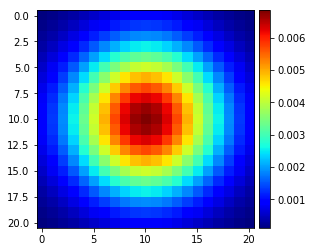

In [3]:
# http://subsurfwiki.org/wiki/Gaussian_filter
def gaussian_kernel(size = 10, size_y=None, sigma = 6):
    size = int(size/2)
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = np.mgrid[-size:size+1, -size_y:size_y+1]
    g = np.exp(-(x**2/float(2*sigma**2)+y**2/float(2*sigma**2)))
    return g / g.sum()
 
# Make the Gaussian by calling the function
gaussian_kernel_array = gaussian_kernel(size = 20, sigma = 5)
 
im = plt.imshow(gaussian_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
add_colorbar(im)
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

Draw a surface plot from a 2D matrix

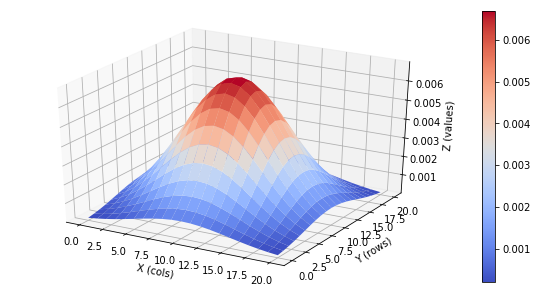

In [4]:
from mpl_toolkits.mplot3d import Axes3D

def surface_plot (matrix, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)


# m.shape must be (10,10)

(fig, ax, surf) = surface_plot(gaussian_kernel_array, cmap=plt.cm.coolwarm)

fig.colorbar(surf)

ax.set_xlabel('X (cols)')
ax.set_ylabel('Y (rows)')
ax.set_zlabel('Z (values)')

plt.show()

Slide a window of a given size, with a given step size, across a 2D Matrix.

In [5]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

# Read RGB and depth image

In [6]:
rgbimg = cv2.imread('rgb.jpg')
rgbimg = cv2.cvtColor(rgbimg, cv2.COLOR_RGB2BGR)
depthimg = cv2.imread('depth.jpg',0)

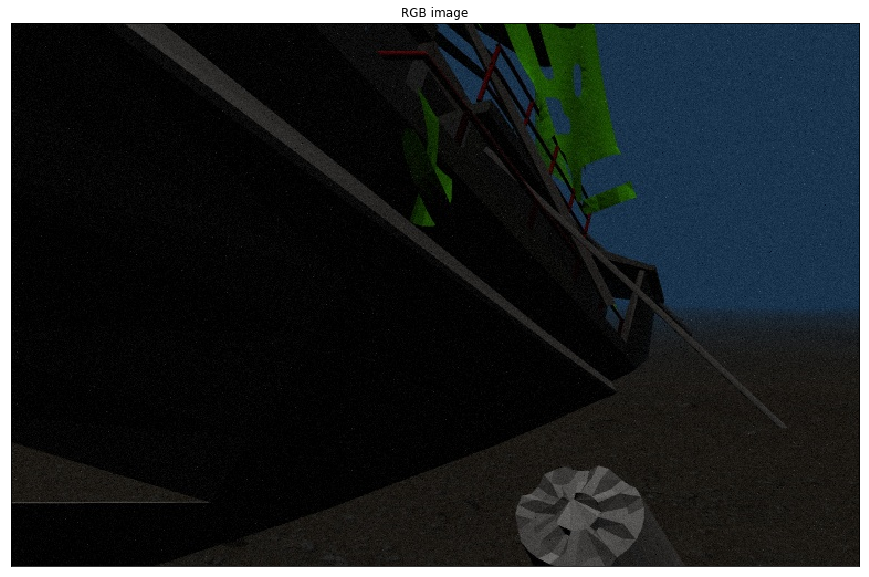

In [46]:
plt.imshow(rgbimg);
plt.xticks([]), plt.yticks([])
plt.title("RGB image");

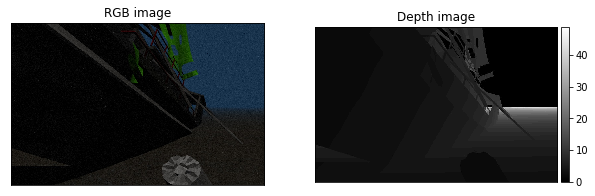

In [7]:
plt.subplot(121),plt.imshow(rgbimg)
plt.title('RGB image'),plt.xticks([]), plt.yticks([])

plt.subplot(122)
im = plt.imshow(depthimg, cmap = 'gray')
add_colorbar(im)
plt.title('Depth image')

plt.rcParams['figure.figsize'] = [20, 10]
plt.xticks([]), plt.yticks([])
plt.show()

# Gaussian blurring with distance

First, we test a simple gaussian blurring that linearly increases with distance

In [8]:
# define the window width and height
gauss_clone = rgbimg.copy()
gauss_image = np.zeros((rgbimg.shape[0],rgbimg.shape[1]), np.float32)
(winW, winH) = (21, 21)
print(np.amax(depthimg))

for (x, y, window) in sliding_window(gauss_clone, stepSize=17, windowSize=(winW, winH)):
	# if the window does not meet our desired window size, ignore it
	if window.shape[0] != winH or window.shape[1] != winW:
		continue

	sig = np.mean(depthimg[y:y + winW, x:x + winH])
	if sig <= 0:
		sig = 100
    
	
	#gauss_clone[y:y + winW, x:x + winH] = cv2.GaussianBlur(window,(winW, winH), int(sig))
	kernel = gaussian_kernel(size = winW, sigma = sig)
	gauss_image[y:y + winW, x:x + winH] = gauss_image[y:y + winW, x:x + winH] + kernel
	gauss_clone[y:y + winW, x:x + winH] = cv2.filter2D(gauss_clone[y:y + winW, x:x + winH],-1,kernel)
	

	# since we do not have a classifier, we'll just draw the window
	#gauss_clone = rgbimg.copy()
	#cv2.rectangle(gauss_clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
	#cv2.imshow("Window", gauss_clone)
	#cv2.waitKey(1)

49


Distances measured at different parts of the image

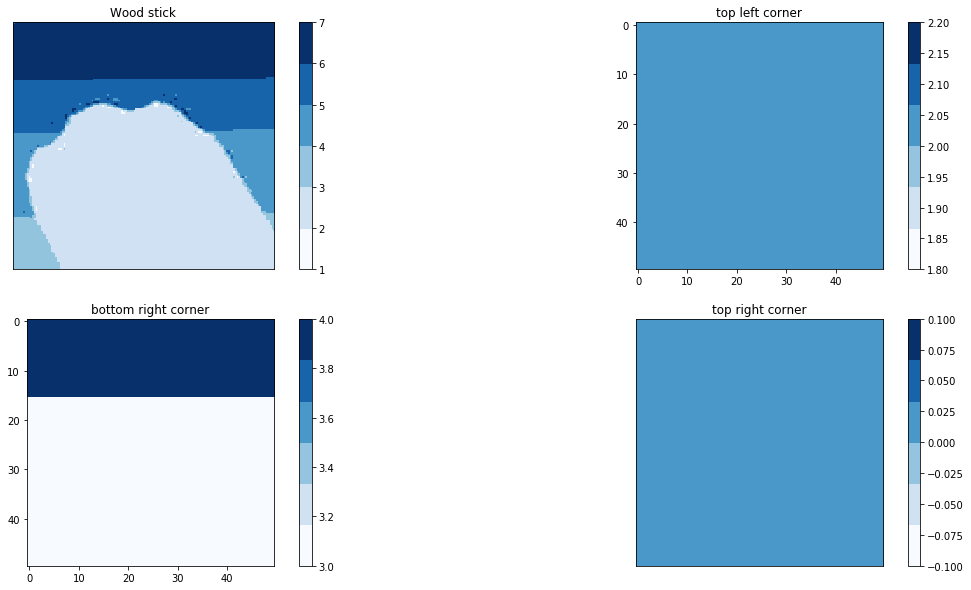

In [9]:
plt.subplot(221),plt.imshow(depthimg[350:492, 450:600], cmap=plt.cm.get_cmap('Blues', 6)),plt.title('Wood stick')
plt.xticks([]), plt.yticks([]),plt.colorbar()

plt.subplot(222),plt.imshow(depthimg[0:50, 0:50], cmap=plt.cm.get_cmap('Blues', 6))
plt.title('top left corner'),plt.colorbar()

plt.subplot(223),plt.imshow(depthimg[442:492, 718:768], cmap=plt.cm.get_cmap('Blues', 6))
plt.title('bottom right corner'),plt.colorbar()

plt.subplot(224),plt.imshow(depthimg[0:50, -100:-50], cmap=plt.cm.get_cmap('Blues', 6))
plt.title('top right corner'),plt.colorbar()

plt.xticks([]), plt.yticks([])
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

Resulting kernel shape at the given parts of the image

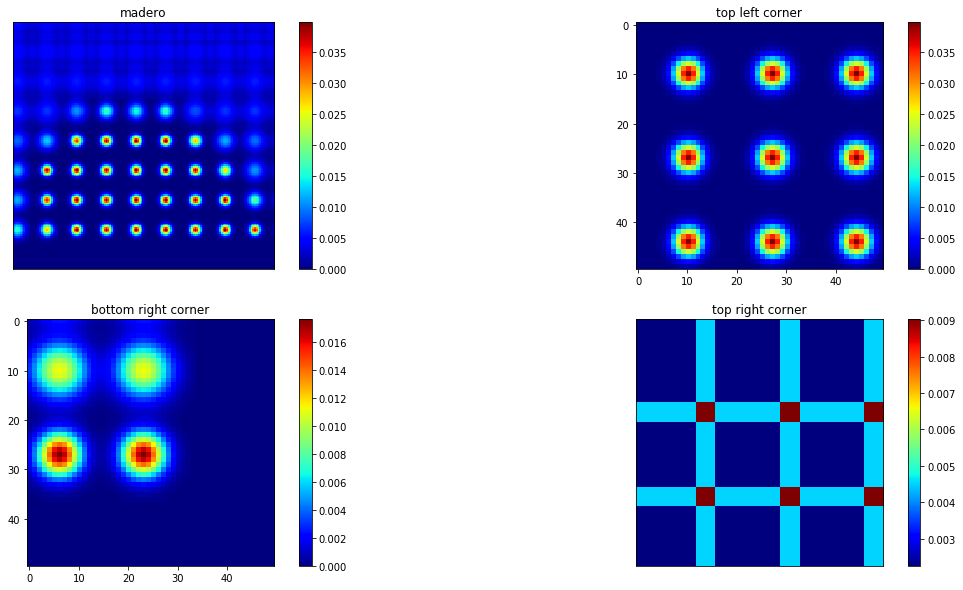

In [10]:
plt.subplot(221),plt.imshow(gauss_image[350:492, 450:600], cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('madero')
plt.xticks([]), plt.yticks([]),plt.colorbar()

plt.subplot(222),plt.imshow(gauss_image[0:50, 0:50], cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('top left corner'),plt.colorbar()

plt.subplot(223),plt.imshow(gauss_image[442:492, 718:768], cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('bottom right corner'),plt.colorbar()

plt.subplot(224),plt.imshow(gauss_image[0:50, -100:-50], cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('top right corner')

plt.xticks([]), plt.yticks([]),plt.colorbar()
plt.show()

Resulting image vs Original image

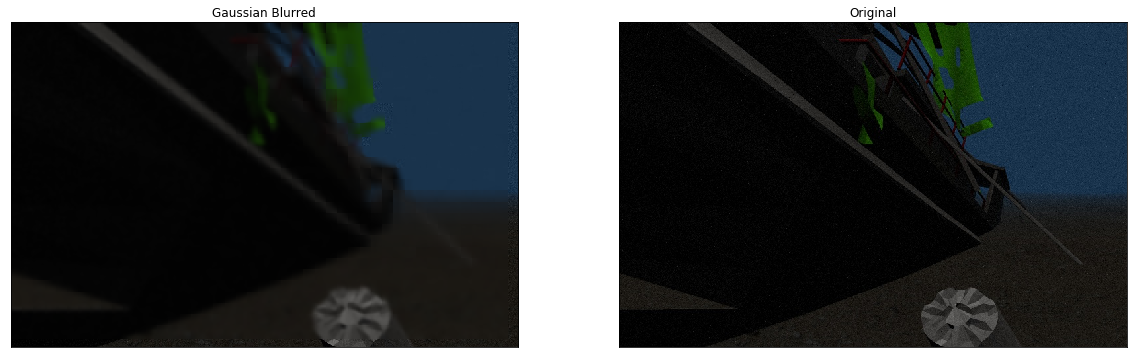

In [11]:
plt.subplot(121),plt.imshow(gauss_clone),plt.title('Gaussian Blurred')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(rgbimg),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.show()

# Point Spread Function

We define the point spread function, which considers the redistribution of power in presence of scattering and absorption. A greater absorption decreases the energy in the point spread function, while a greater scattering implies a larger size of point spreading.
This can be expressed as a convolution integral:

$I_2(x,y) = I_1(x_p,y_p) * S(x,y,z')$

Here we define a custom kernel for the Point Spread Function and test it at different depths

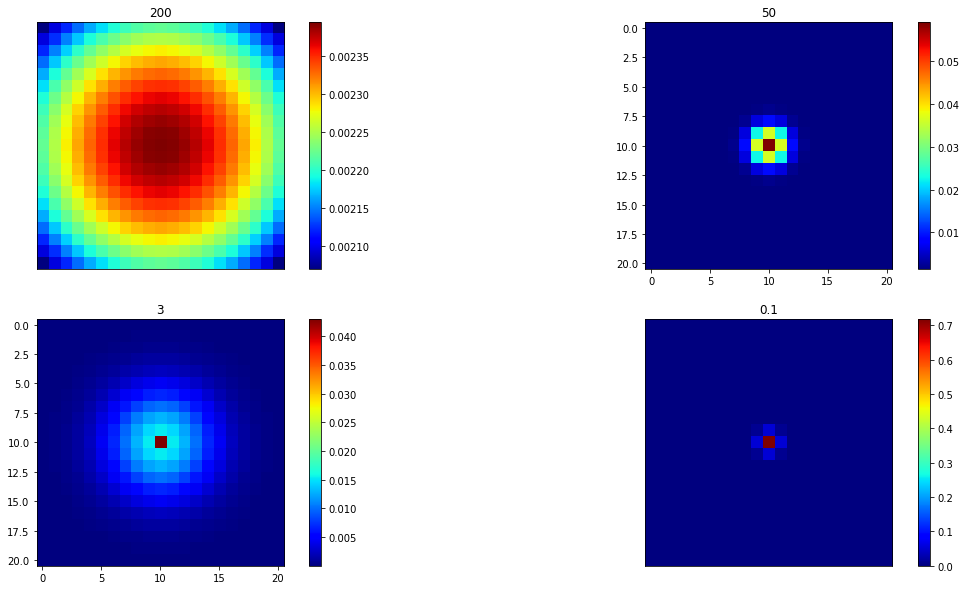

In [12]:
def PSF_kernel(size = 10, size_y=None, sigma = 6, depth = 0):
    size = int(size/2)
    center = size/10
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = np.mgrid[-size:size+1, -size_y:size_y+1]
    g = np.exp(-((x)**2/float(2*(sigma+0.1)**2)+(y)**2/float(2*(sigma+0.1)**2)))/(2*np.pi*(sigma+0.1)**2)+np.exp(-((x)**2/float(2*(0.1*depth)**2)+(y)**2/float(2*(0.1*depth)**2)))/(2*np.pi*(0.8*depth)**2)
    return g / g.sum()
 
# Make the Gaussian by calling the function
PSF_kernel_array = PSF_kernel(size = 20, sigma = 200, depth = 200)
 
plt.subplot(221),plt.imshow(PSF_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('200')
plt.xticks([]), plt.yticks([]),plt.colorbar()

PSF_kernel_array = PSF_kernel(size = 20, sigma = 50, depth = 10)

plt.subplot(222),plt.imshow(PSF_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('50'),plt.colorbar()

PSF_kernel_array = PSF_kernel(size = 20, sigma = 3, depth = 3)

plt.subplot(223),plt.imshow(PSF_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('3'),plt.colorbar()

PSF_kernel_array = PSF_kernel(size = 20, sigma = 0.5, depth = 0.5)

plt.subplot(224),plt.imshow(PSF_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('0.1')

plt.xticks([]), plt.yticks([]),plt.colorbar()
plt.show()

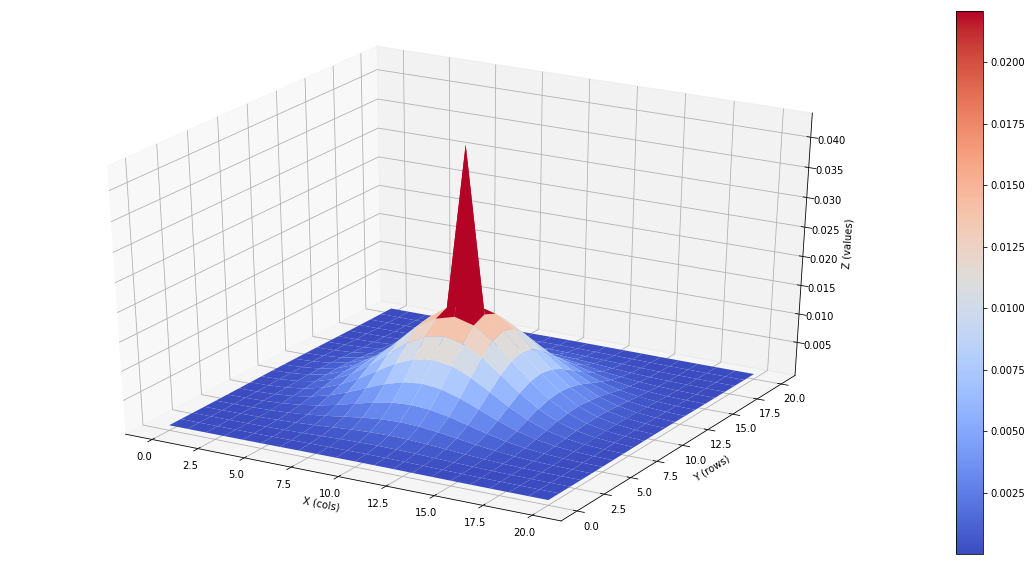

In [13]:
(fig, ax, surf) = surface_plot(PSF_kernel(size = 20, sigma = 3, depth = 3), cmap=plt.cm.coolwarm)
#plt.subplot(221)
fig.colorbar(surf)
ax.set_xlabel('X (cols)')
ax.set_ylabel('Y (rows)')
ax.set_zlabel('Z (values)')

plt.show()

### With the custom kernel

In [16]:
# define the window width and height
direct_clone = rgbimg.copy()
depthcorrected = np.where(depthimg!=0, depthimg, 200)
(winW, winH) = (17, 17)

for (x, y, window) in sliding_window(direct_clone, stepSize=7, windowSize=(winW, winH)):
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue

    #sig = np.exp(-0.2*depthcorrectede[y:y + winW, x:x + winH])
    sig = PSF_kernel(size = winW, 
                     sigma = depthcorrected[int(y+winW/2),int(x+winH/2)],
                     depth = depthcorrected[int(y+winW/2),int(x+winH/2)])#+np.exp(-6.9*depthcorrected[y:y + winW, x:x + winH])

    direct_clone[y:y + winW, x:x + winH] = cv2.filter2D(rgbimg[y:y + winW, x:x + winH],-1,sig)


### With the gauss kernel

In [17]:
# define the window width and height
gauss_clone  = rgbimg.copy()
depthcorrected = np.where(depthimg!=0, depthimg, 200)
(winW, winH) = (17, 17)

for (x, y, window) in sliding_window(direct_clone, stepSize=11, windowSize=(winW, winH)):
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue

    gauss_clone[y:y + winW, x:x + winH]  = cv2.GaussianBlur(gauss_clone[y:y + winW, x:x + winH],
                                                            (winW, winH),
                                                            0.1*depthcorrected[int(y+winW/2),int(x+winH/2)])
    gauss_clone[y:y + winW, x:x + winH]  = cv2.GaussianBlur(gauss_clone[y:y + winW, x:x + winH],
                                                            (winW, winH),
                                                            0.2*depthcorrected[int(y+winW/2),int(x+winH/2)])

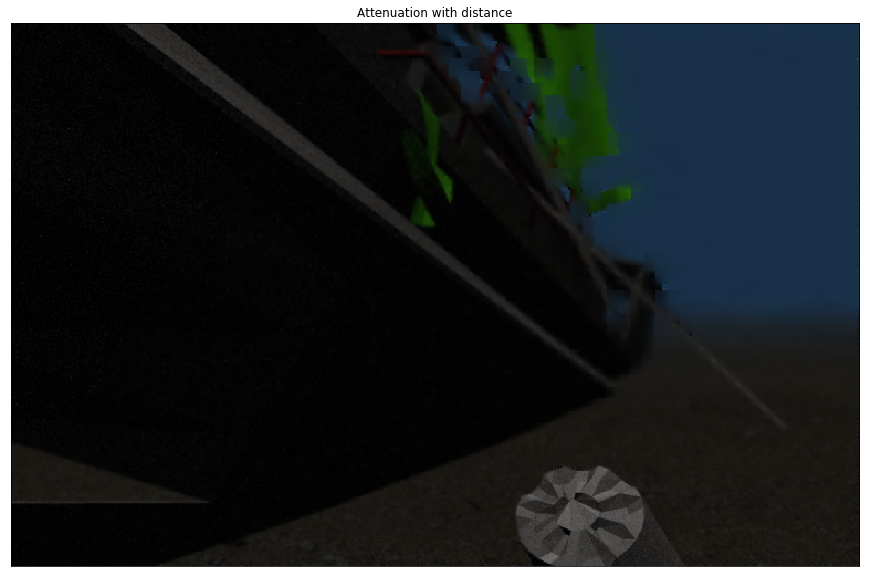

In [18]:
plt.imshow(gauss_clone);
plt.xticks([]), plt.yticks([])
plt.title("Attenuation with distance");

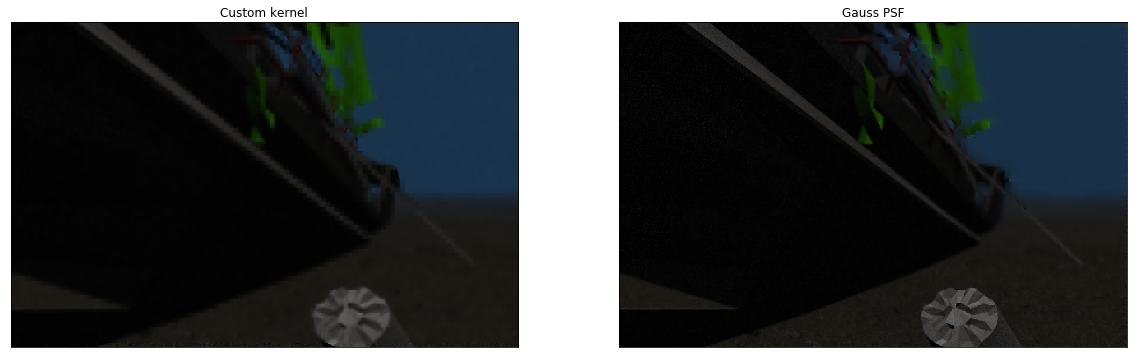

In [19]:
#clone = rgbimg.copy()
#dst = cv2.filter2D(clone,-1,gauss_image)
plt.subplot(121),plt.imshow(direct_clone),plt.title('Custom kernel')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(gauss_clone),plt.title('Gauss PSF')
plt.xticks([]), plt.yticks([])
plt.show()

# Style transfer of image

In [36]:
from torchvision import transforms
from transformer_net import TransformerNet
import torch
import re

stylized  = gauss_clone.copy()
content_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.mul(255))
                            ])

content_image = content_transform(stylized)
content_image = content_image.unsqueeze(0).to('cpu')


with torch.no_grad():
            style_model = TransformerNet()
            state_dict = torch.load('../models/uw_turbid.model')
            # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
            for k in list(state_dict.keys()):
                if re.search(r'in\d+\.running_(mean|var)$', k):
                    del state_dict[k]
            style_model.load_state_dict(state_dict)
            style_model.to('cpu')

            output = style_model(content_image).cpu()
            img = output[0].clone().clamp(0, 255).numpy()
            img = img.transpose(1, 2, 0).astype("uint8")
            #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

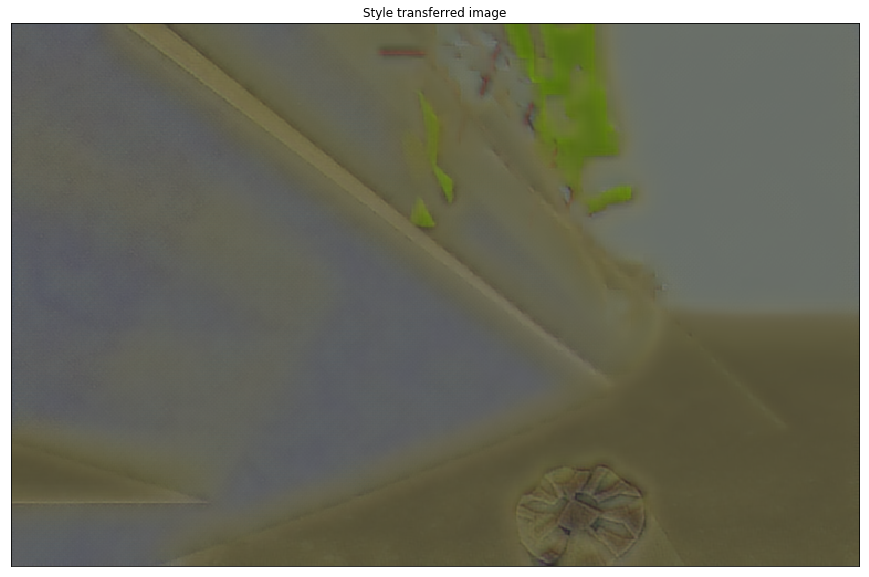

In [37]:
plt.imshow(img);
plt.xticks([]), plt.yticks([])
plt.title("Style transferred image");

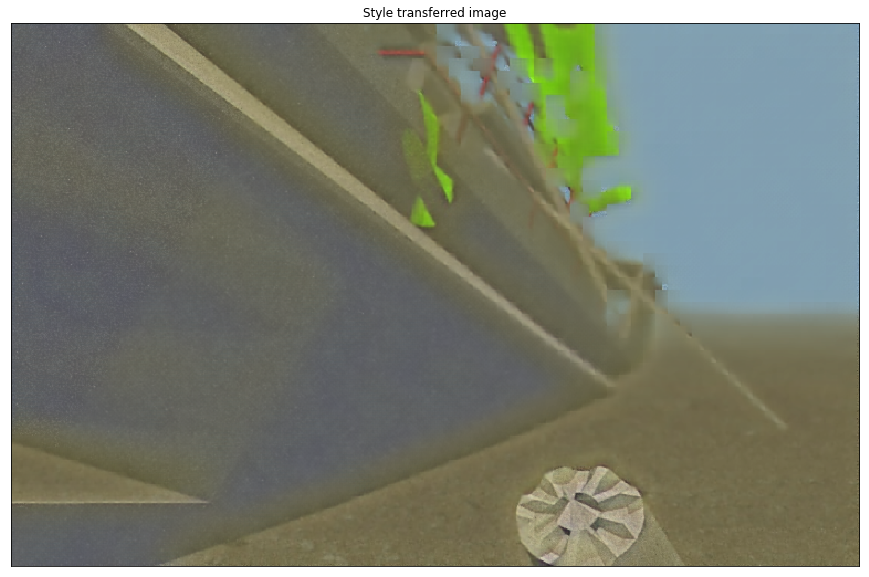

In [50]:
res = img+gauss_clone
plt.imshow(res);
plt.xticks([]), plt.yticks([])
plt.title("Style transferred image");

## Frequency domain

First, obtain optimal size of the image, and then generate a new image with this size where we fill the extra pixels with zero values.

PSF  is  used  as  an  indicator  to  identify  the objective  lens  problems.  Its  analysis  is  used  to  determine the   resolution   and   to   identify   the   problems   with   the microscopic  images.  It  is  used  to  analyze  the  out  of  focus images,   to   generate   and   display   aberrated   structure   of image.In   under   water   images,   PSF   can   predict   the underwater   light   propagation   and   under   water   image quality.  When  the  image  is  degraded,  we  can  restore  it  by estimating   the   PSF   of   an   image   system    with    the deconvolution  but  we  should  have  a  better  knowledge  of degradation and then it must be estimate and modeled.In   underwater   imaging,   degradation   sources   are –turbidity,  floating  particles  light  propagation  properties  in water  (optical  properties)  and  these  are  incorporated  in  to PSF.By definition,

$g(a,b) = f(a,b)*h(a,b)+n(a,b)$

Where $g(a,b)$ is the observed image, $f(a,b)$ is the original image, $h(a,b)$ is the PSF and $n(a,b)$ the noise.
In the frequency domain,

$G(a,b) = F(a,b)H(a,b)+N(a,b)$

Where H is the Optical Transfer Function (OTF) and its magnitude called the Modulation Transfer Function (MTF).
These  functions  are  used  when  image  is  degraded  with contrast and resolution

https://watermark.silverchair.com/361-3-861.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAlAwggJMBgkqhkiG9w0BBwagggI9MIICOQIBADCCAjIGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMhAJFw7cv0qozcs8rAgEQgIICA7PAODqKI2620FeSouyPup0L4V3Ot5yhnU7i_rQamVNGsCGTZPt0p2qEp6PMdENpll8xndr7t1_Uzlx5GmLMut7vKFJ5NiPCszKqwzrpPf7nxmKYGSgzoUyY4rlUjNtoQi1fhxtOCt__-LznRtRCnxnoL0VCp2YUCjkY-u1FLvugQTmBgO5OnN0uaQlq6eOhW6xGt7zsZwoX9c3KhpvdzvZnbr0soPWLciRVd2MCSIfMstAlvYPW2VvEU5Neeo2wDKUPxjMH4cu3EW4Y2sKSydIUStEKKKQgIFBJIoEEliDEZZ7QP8aK4zmFjCUskSzkh0POF8tgyIn-aqW436dXpwhfAaj6xncwLrOUtG66BCGhPV3RVDNwKpCY2hgCAn532AM0uHICxSDH5UmbsLziPKi5hZdxtyRdIEKBId7Q9l-P03XBgMHYIdKzqNp0YFSvxkFyD7fOAo4jFsxuOif8P5Kn1pj52BMrP7siYxUibKs3-bfy_mSB6dC4eFo-7WmjZQ813bFGpNRzTS2hm4Q8ipFOxhbZKSR4ZyyWfdW5v9rCXrV9ow2PWiKtrdElEHzkqWTIr7rCxU7JldaMkeJt9wFfeGkeHrcqdB00HOLy149uTLkSOQBxs6PWu9FwNkVhnbKnEDnUA26iJS07IZUEtUH9vYp5VsUubsXZeOnbWLB0GYLG

The following 21-px-widedamped sinc functioninterpolant doesan excellent job interpolating discrete PSF (Mighell 2002)

$ f_{shifted}(x_0) = \sum_{i = -10}^{10} f(x_i) sin(\pi(x_i-x_0))/(\pi(x_i-x_0) exp[-((x_i-x_0)/3.25)^2]$

Note that since the two-dimensional sinc function is separable inxandy, this interpolant can be coded to be computationally fastand efficient.

Aliasing problems due to critically sampled or undersampled datamay be overcome by using discrete PSFs that aresupersampledattwo, three or more times more finely than the observational data. Inorder to have a realistic observational model, once the supersampleddiscrete PSF has been interpolated to the correct position, a newdegraded(rebinned) version of the discrete PSF must be createdthat has the same spatial resolution as the observational data.